In [1]:
from dotenv import load_dotenv
import pymongo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import humanize
import plotly.express as px
import warnings
import os

In [2]:
sns.set_style('darkgrid')
plt.rcParams['figure.dpi'] = 80
warnings.filterwarnings('ignore')
load_dotenv()

True

In [3]:
client = pymongo.MongoClient(os.getenv('MONGO_URI'))
db = client[os.getenv('MONGO_DATABASE')]
collection = db['scrapy_bogota_apartments_processed']

apartments = pd.DataFrame(list(collection.find()))
apartments = apartments.drop(columns=['_id'], axis=1)
apartments = apartments.loc[(apartments['tipo_operacion'] == 'VENTA') & (apartments['coords_modified'] == False)]

usaquen = apartments.loc[apartments['localidad'] == 'USAQUEN']
usaquen.head()

codigo             tipo_propiedad tipo_operacion  precio_venta   area  \
1   3889852                APARTAMENTO          VENTA   223000000.0   63.0   
4   4063762                APARTAMENTO          VENTA   222800000.0   48.0   
12  2834736                APARTAMENTO          VENTA   291750503.0   73.0   
13  2297364  CASA CON CONJUNTO CERRADO          VENTA   720000000.0  170.0   
17  3145170                APARTAMENTO          VENTA   423300000.0   86.0   

    habitaciones  banos  administracion  parqueaderos               sector  \
1            3.0    2.0             NaN           0.0  SAN CRISTOBAL NORTE   
4            3.0    2.0        151000.0           0.0             VERBENAL   
12           3.0    2.0         50000.0           1.0             VERBENAL   
13           4.0    4.0        500000.0           2.0           LOS CEDROS   
17           3.0    2.0        666700.0           2.0           LOS CEDROS   

    ...  vigilancia coords_modified  localidad                      barrio  \
1   ...         0.0           False    USAQUEN  BARRANCAS PERLAS DEL NORTE   
4   ...         0.0           False    USAQUEN          HORIZONTES USAQUEN   
12  ...         0.0           False    USAQUEN         VILLAS DE ANDALUCIA   
13  ...         0.0           False    USAQUEN                LOS CEDRITOS   
17  ...         0.0           False    USAQUEN                 EL CONTADOR   

                    estacion_tm_cercana distancia_estacion_tm_m  \
1                               Mazurén                 2384.89   
4                              Terminal                 2099.16   
12                            Calle 187                 1292.57   
13                            Calle 146                  777.38   
17  Alcalá – Colegio S. Tomás Dominicos                  823.67   

   is_cerca_estacion_tm                                   parque_cercano  \
1                     0                         PARQUE ZONAL ALTA BLANCA   
4                     0             PARQUE VECINAL DESARROLLO VERBENAL I   
12                    0  PARQUE VECINAL URBANIZACIÓN CALLE 170 / ALAMEDA   
13                    0     PARQUE VECINAL DESARROLLO ESTRELLA DEL NORTE   
17                    0     PARQUE VECINAL NUEVA URBANIZACIÓN EL CEDRITO   

   distancia_parque_m is_cerca_parque  
1              472.47               1  
4             1661.14               0  
12             560.15               0  
13            1213.86               0  
17            1210.55               0  

[5 rows x 45 columns]

In [4]:
# apartments = pd.read_csv('../../data/processed/apartments.csv', low_memory=False)
# usaquen =  apartments[(apartments['tipo_operacion'] == 'VENTA') & (apartments['localidad'] == 'USAQUEN') & (apartments['coords_modified'] == False)]
# usaquen = usaquen.drop(columns=['precio_arriendo'])
# usaquen.head()

In [6]:
usaquen.datetime = pd.to_datetime(usaquen.datetime)
usaquen['last_view'] = pd.to_datetime(usaquen['last_view'])

In [7]:
usaquen.shape

(9695, 45)

In [8]:
usaquen.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9695 entries, 1 to 43011
Data columns (total 45 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   codigo                   9695 non-null   object        
 1   tipo_propiedad           9695 non-null   object        
 2   tipo_operacion           9695 non-null   object        
 3   precio_venta             9695 non-null   float64       
 4   area                     9695 non-null   float64       
 5   habitaciones             9695 non-null   float64       
 6   banos                    9695 non-null   float64       
 7   administracion           8958 non-null   float64       
 8   parqueaderos             9695 non-null   float64       
 9   sector                   9465 non-null   object        
 10  estrato                  9695 non-null   float64       
 11  antiguedad               9692 non-null   object        
 12  latitud                  9695 non-null

In [9]:
usaquen.columns

Index(['codigo', 'tipo_propiedad', 'tipo_operacion', 'precio_venta', 'area',
       'habitaciones', 'banos', 'administracion', 'parqueaderos', 'sector',
       'estrato', 'antiguedad', 'latitud', 'longitud', 'direccion',
       'descripcion', 'website', 'last_view', 'datetime', 'url', 'timeline',
       'estado', 'compañia', 'precio_arriendo', 'jacuzzi', 'piso', 'closets',
       'chimenea', 'permite_mascotas', 'gimnasio', 'ascensor',
       'conjunto_cerrado', 'piscina', 'salon_comunal', 'terraza', 'vigilancia',
       'coords_modified', 'localidad', 'barrio', 'estacion_tm_cercana',
       'distancia_estacion_tm_m', 'is_cerca_estacion_tm', 'parque_cercano',
       'distancia_parque_m', 'is_cerca_parque'],
      dtype='object')

In [10]:
def format_tick_humanize(value, tick_number):
    return humanize.intword(value)

# Eliminar outliers

Eliminamos los precios que son outliers

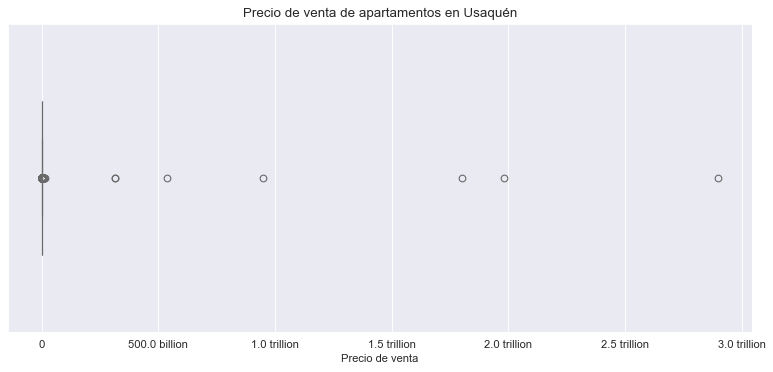

In [11]:
plt.figure(figsize=(12, 5))

sns.boxplot(
    usaquen,
    x='precio_venta',
    width=.5,
    palette='Set3',
)

plt.title('Precio de venta de apartamentos en Usaquén')
plt.xlabel('Precio de venta')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

In [12]:
Q1 = usaquen['precio_venta'].quantile(0.25)
Q3 = usaquen['precio_venta'].quantile(0.75)

IQR = Q3 - Q1

lower = Q1 - (1.5 * IQR)
if lower < 0:
    lower = Q1 - (0.5 * IQR)
upper = Q3 + (1.5 * IQR)

outliers = usaquen[(usaquen['precio_venta'] < lower) | (usaquen['precio_venta'] > upper)]
outliers.shape

(560, 45)

In [13]:
usaquen = usaquen[(usaquen['precio_venta'] > lower) & (usaquen['precio_venta'] < upper)]
usaquen.shape

(9135, 45)

# Analisis Univariado

## Area (m2)

### Eliminar outliers

In [14]:
# eliminar area igual a 0

usaquen = usaquen[usaquen['area'] > 0]

Eliminamos las areas (m2) que son outliers

In [15]:
Q1 = usaquen['area'].quantile(0.25)
Q3 = usaquen['area'].quantile(0.75)

IQR = Q3 - Q1

lower = Q1 - (1.5 * IQR)
upper = Q3 + (1.5 * IQR)

outliers = usaquen[(usaquen['area'] < lower) | (usaquen['area'] > upper)]
outliers.shape

(193, 45)

In [16]:
usaquen = usaquen[(usaquen['area'] > lower) & (usaquen['area'] < upper)]
usaquen.shape

(8935, 45)

### Analisis

In [17]:
usaquen.area.describe().apply(lambda x: humanize.intcomma(x)).to_frame().T

count                mean                std  min   25%    50%    75%  \
area  8,935.0  126.98615556799105  60.22913132661473  1.0  80.0  115.0  166.0   

        max  
area  304.0

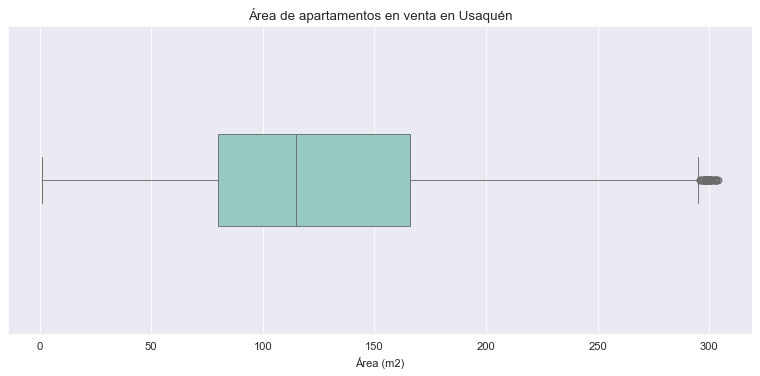

In [18]:
plt.figure(figsize=(12, 5))

sns.boxplot(
    data=usaquen,
    x='area',
    width=.3,
    palette='Set3',
    linewidth=.8,
)

plt.title('Área de apartamentos en venta en Usaquén')
plt.xlabel('Área (m2)')
plt.show()

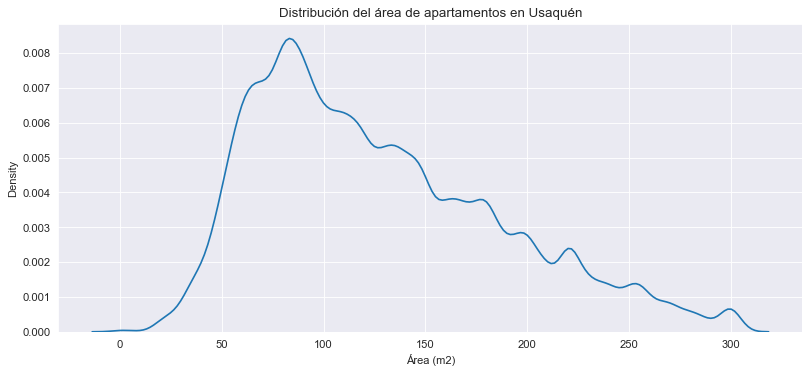

In [19]:
plt.figure(figsize=(12, 5))

sns.kdeplot(
    usaquen,
    x='area',
    bw_adjust=.5,
)

plt.title('Distribución del área de apartamentos en Usaquén')
plt.xlabel('Área (m2)')
plt.show()

### Cercania a Transmilenio

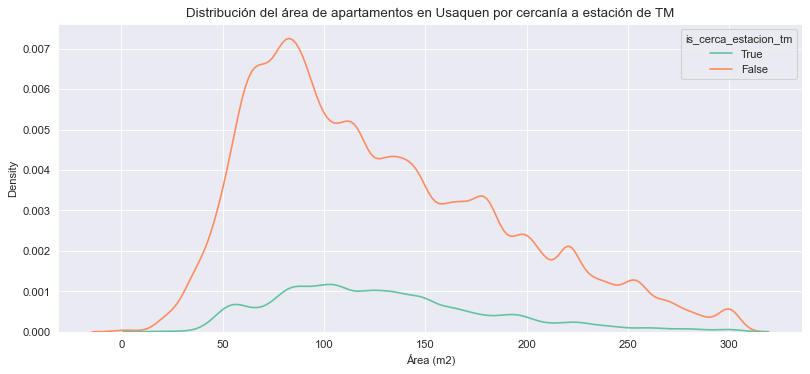

In [20]:
plt.figure(figsize=(12, 5))

sns.kdeplot(
    usaquen,
    x='area',
    bw_adjust=.5,
    hue='is_cerca_estacion_tm',
    palette='Set2',
    hue_order=[True, False],
)

plt.title('Distribución del área de apartamentos en Usaquen por cercanía a estación de TM')
plt.xlabel('Área (m2)')
plt.show()

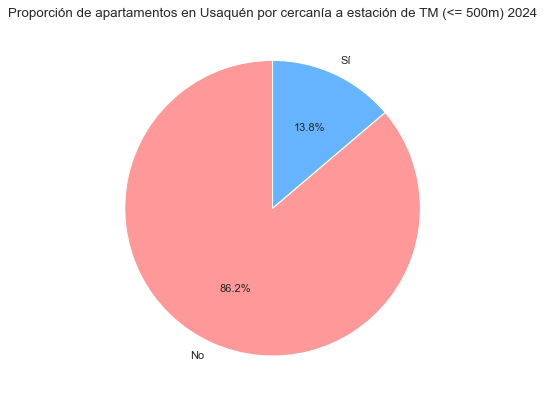

In [23]:
# pie chart
plt.figure(figsize=(6, 6))

usaquen['is_cerca_estacion_tm'].value_counts().plot.pie(
    autopct='%1.1f%%',
    colors=['#ff9999', '#66b3ff'],
    startangle=90,
    labels=['No', 'Sí'],
)

plt.title('Proporción de apartamentos en Usaquén por cercanía a estación de TM (<= 500m) 2024')
plt.ylabel('')
plt.show()

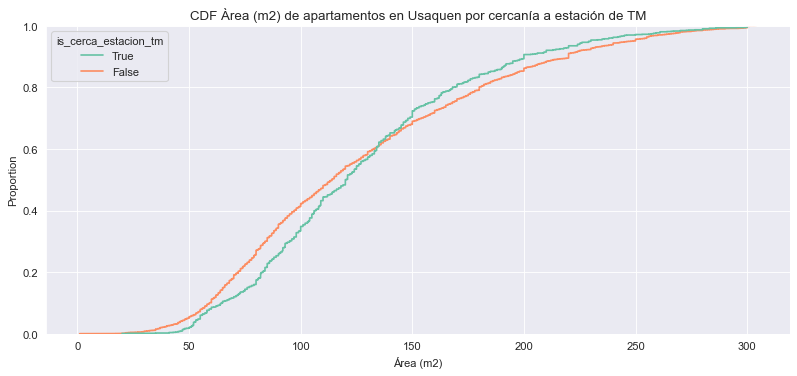

In [21]:
plt.figure(figsize=(12, 5))

sns.ecdfplot(
    usaquen,
    x='area',
    hue='is_cerca_estacion_tm',
    palette='Set2',
    hue_order=[True, False],
)

plt.title('CDF Àrea (m2) de apartamentos en Usaquen por cercanía a estación de TM')
plt.xlabel('Área (m2)')
plt.show()


### Estrato

In [24]:
usaquen.groupby('estrato')['area'].describe().applymap(lambda x: round(x, 1))

count   mean   std   min    25%    50%    75%    max
estrato                                                       
1.0         2.0   96.0  11.3  88.0   92.0   96.0  100.0  104.0
2.0        33.0   61.1  46.4  31.0   45.0   45.0   62.6  300.0
3.0       327.0   66.3  37.1  29.0   46.0   60.0   70.0  300.0
4.0      1872.0   84.7  29.5   2.0   65.5   81.0   98.0  280.0
5.0      2214.0  119.1  51.8   1.0   82.0  112.0  147.0  302.7
6.0      4487.0  153.5  60.4   1.0  108.0  149.0  196.0  304.0

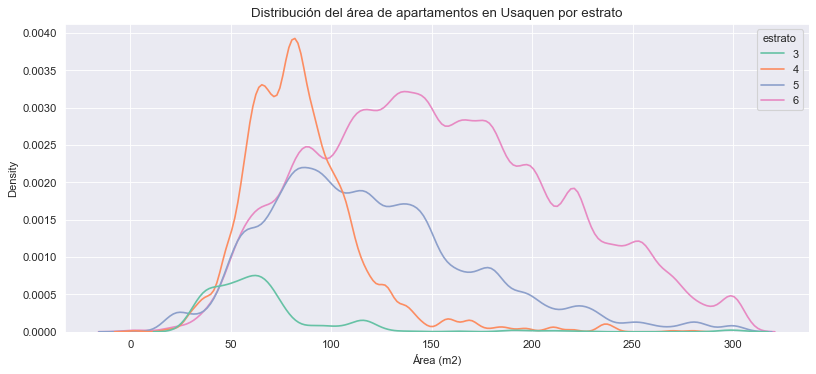

In [25]:
plt.figure(figsize=(12, 5))

sns.kdeplot(
    usaquen,
    x='area',
    bw_adjust=.5,
    hue='estrato',
    hue_order=[3, 4, 5, 6],
    palette='Set2',
)

plt.title('Distribución del área de apartamentos en Usaquen por estrato')
plt.xlabel('Área (m2)')
plt.show()

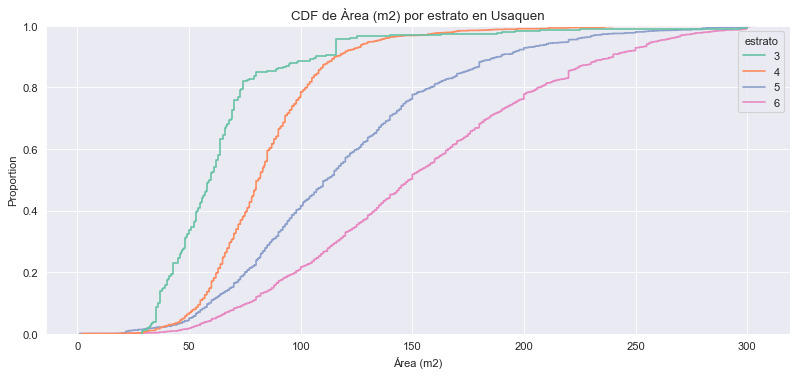

In [26]:
plt.figure(figsize=(12, 5))

sns.ecdfplot(
    usaquen,
    x='area',
    hue='estrato',
    palette='Set2',
    hue_order=[3, 4, 5, 6],
)

plt.title('CDF de Àrea (m2) por estrato en Usaquen')
plt.xlabel('Área (m2)')
plt.show()

### Antiguedad

In [27]:
usaquen.groupby('antiguedad')['area'].describe().applymap(lambda x: round(x, 1))

count   mean   std   min   25%    50%    75%    max
antiguedad                                                              
EN CONSTRUCCION       12.0   67.1  20.4  50.0  52.9   60.3   72.3  110.0
ENTRE 0 Y 5 ANOS    1126.0   94.6  48.5   1.0  59.0   82.0  125.0  300.0
ENTRE 10 Y 20 ANOS  2540.0  130.6  59.6   1.0  84.2  117.6  169.0  302.7
ENTRE 5 Y 10 ANOS   1263.0  112.0  51.4  27.0  73.0  100.0  140.0  290.0
MAS DE 20 ANOS      3616.0  139.7  61.6   1.0  89.9  129.0  180.0  304.0
REMODELADO           328.0  141.7  58.2  22.6  89.8  140.0  180.0  300.0
SOBRE PLANOS          49.0   44.0  21.6  21.0  22.3   42.5   61.5  105.3

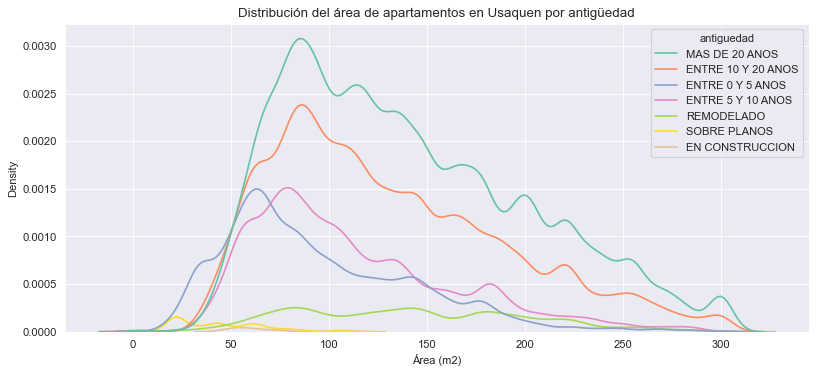

In [28]:
plt.figure(figsize=(12, 5))

sns.kdeplot(
    usaquen,
    x='area',
    bw_adjust=.5,
    hue='antiguedad',
    palette='Set2',
)

plt.title('Distribución del área de apartamentos en Usaquen por antigüedad')
plt.xlabel('Área (m2)')
plt.show()

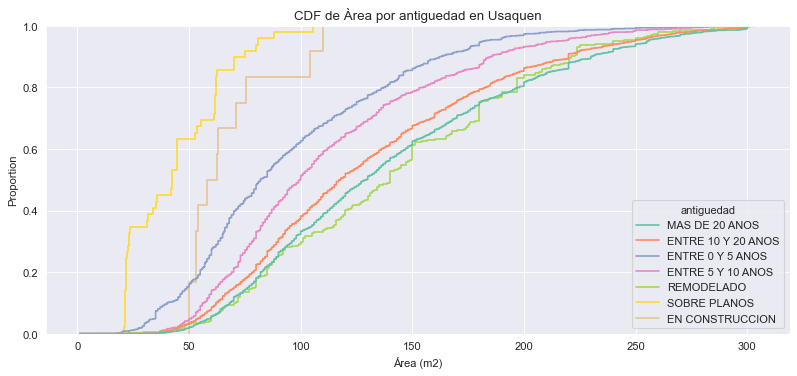

In [29]:
plt.figure(figsize=(12, 5))

sns.ecdfplot(
    usaquen,
    x='area',
    hue='antiguedad',
    palette='Set2',
)

plt.title('CDF de Àrea por antiguedad en Usaquen')
plt.xlabel('Área (m2)')
plt.show()

Lo apartamentos mas recientes tienden a tener un Àrea menor que los mas antiguos

### Estacion de TM Cercana

In [30]:
estacion_tm_cercana = usaquen[usaquen['is_cerca_estacion_tm'] == True]
estacion_tm_cercana_stats = estacion_tm_cercana.groupby('estacion_tm_cercana')['area'].describe().applymap(lambda x: round(x, 1)).sort_values(by='mean', ascending=False)
estacion_tm_cercana_stats

count   mean   std   min    25%    50%  \
estacion_tm_cercana                                                           
Calle 100 - Marketmedios              30.0  151.5  55.4  45.0  111.8  135.0   
Calle 106                            357.0  146.0  51.3  20.0  109.0  140.0   
Calle 127                            198.0  136.3  52.6  22.6   98.0  130.2   
Prado                                119.0  132.8  49.8  51.0   98.0  121.0   
Pepe Sierra                          252.0  132.1  52.2  45.0   91.0  131.5   
Calle 146                             37.0  102.9  45.2  41.0   88.0  102.0   
Alcalá – Colegio S. Tomás Dominicos   92.0   97.2  44.0  47.0   71.9   85.0   
Mazurén                               15.0   93.5  17.3  44.0   93.0   93.0   
Calle 187                             13.0   88.8  27.9  53.0   71.0   87.0   
Calle 142                             94.0   85.6  26.5  41.0   65.2   83.8   
Calle 161                             18.0   64.2  18.2  35.0   53.8   60.9   
Portal Norte                           5.0   63.8   5.3  56.1   63.0   64.0   
Toberin - Foundever                    1.0   60.0   NaN  60.0   60.0   60.0   

                                       75%    max  
estacion_tm_cercana                                
Calle 100 - Marketmedios             209.2  239.5  
Calle 106                            175.0  300.0  
Calle 127                            162.9  300.0  
Prado                                152.5  299.0  
Pepe Sierra                          164.8  280.0  
Calle 146                            107.8  300.0  
Alcalá – Colegio S. Tomás Dominicos  112.4  300.0  
Mazurén                               93.0  130.0  
Calle 187                            100.0  163.0  
Calle 142                            105.0  159.0  
Calle 161                             67.8  113.0  
Portal Norte                          65.0   71.0  
Toberin - Foundever                   60.0   60.0

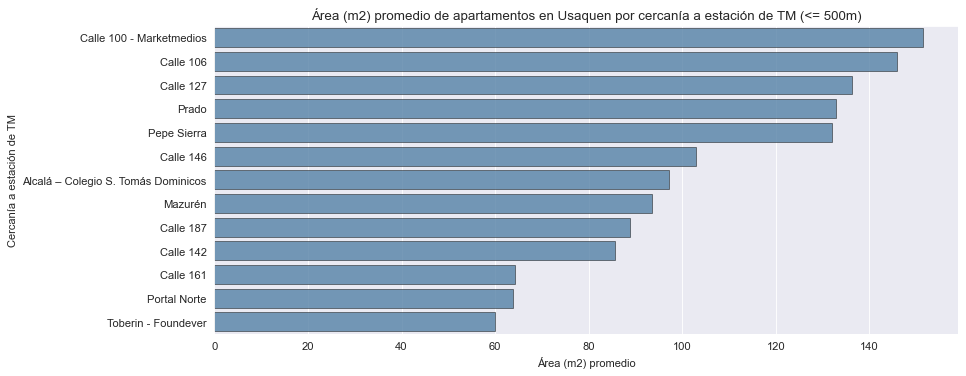

In [31]:
plt.figure(figsize=(12, 5))

sns.barplot(
    estacion_tm_cercana_stats,
    y=estacion_tm_cercana_stats.index,
    x='mean',
    # palette='Set2',
    color='steelblue',
    edgecolor='black',
    linewidth=.5,
    alpha=.8,
)

plt.title('Área (m2) promedio de apartamentos en Usaquen por cercanía a estación de TM (<= 500m)')
plt.xlabel('Área (m2) promedio')
plt.ylabel('Cercanía a estación de TM')
plt.show()

In [32]:
estacion_tm_cercana_stats = estacion_tm_cercana.groupby('estacion_tm_cercana')['area'].describe().applymap(lambda x: round(x, 1)).sort_values(by='50%', ascending=False)

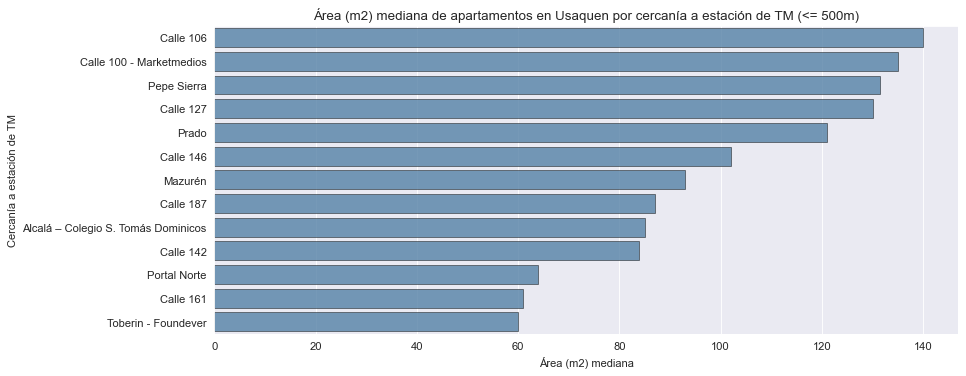

In [33]:
plt.figure(figsize=(12, 5))

sns.barplot(
    estacion_tm_cercana_stats,
    y=estacion_tm_cercana_stats.index,
    x='50%',
    # palette='Set2',
    color='steelblue',
    edgecolor='black',
    linewidth=.5,
    alpha=.8,
)

plt.title('Área (m2) mediana de apartamentos en Usaquen por cercanía a estación de TM (<= 500m)')
plt.xlabel('Área (m2) mediana')
plt.ylabel('Cercanía a estación de TM')
plt.show()

<Figure size 960x400 with 0 Axes>

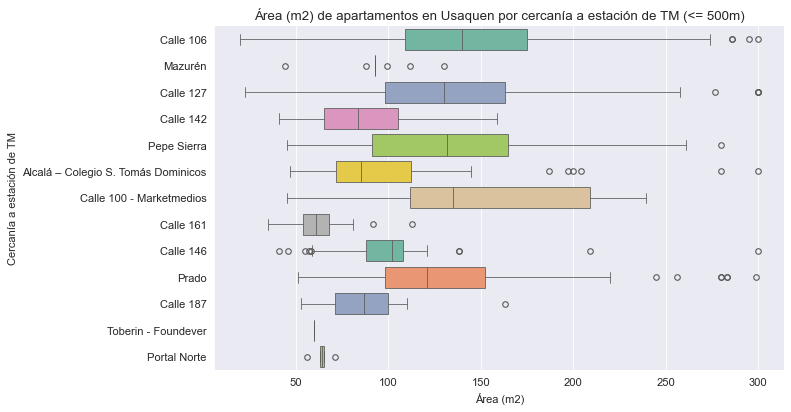

In [34]:
plt.figure(figsize=(12, 5))

sns.catplot(
    data=estacion_tm_cercana,
    x='area',
    y='estacion_tm_cercana',
    kind='box',
    height=5,
    aspect=2,
    palette='Set2',
    orient='h',
    linewidth=.7,
)

plt.title('Área (m2) de apartamentos en Usaquen por cercanía a estación de TM (<= 500m)')
plt.xlabel('Área (m2)')
plt.ylabel('Cercanía a estación de TM')
plt.show()

## Precio de venta

In [36]:
MAPBOX_TOKEN = os.getenv('MAPBOX_TOKEN')

px.set_mapbox_access_token(MAPBOX_TOKEN)

fig = px.scatter_mapbox(
    usaquen,
    lat='latitud',
    lon='longitud',
    color='precio_venta',
    size='area',
    color_continuous_scale=px.colors.cyclical.IceFire,
    size_max=15,
    zoom=11,
    title='Precio de venta y área de apartamentos en Usaquen',
    hover_name='barrio',
    hover_data=['area', 'precio_venta', 'estrato', 'antiguedad', 'is_cerca_estacion_tm', 'estacion_tm_cercana'],
)

fig.update_layout(
    margin=dict(l=0, r=0, t=50, b=0),
    coloraxis_colorbar=dict(
        title='Precio de venta',
        tickformat='s',
    ),
    mapbox=dict(
        style='basic',
    ),
)

fig.write_html('../../html/usaquen_precio_venta_area.html')

fig.show()

In [37]:
usaquen.precio_venta.describe().apply(lambda x: humanize.intword(x)).to_frame().T

count           mean            std            min  \
precio_venta  8.9 thousand  842.3 million  467.9 million  145.0 million   

                        25%            50%          75%          max  
precio_venta  475.0 million  720.0 million  1.1 billion  2.4 billion

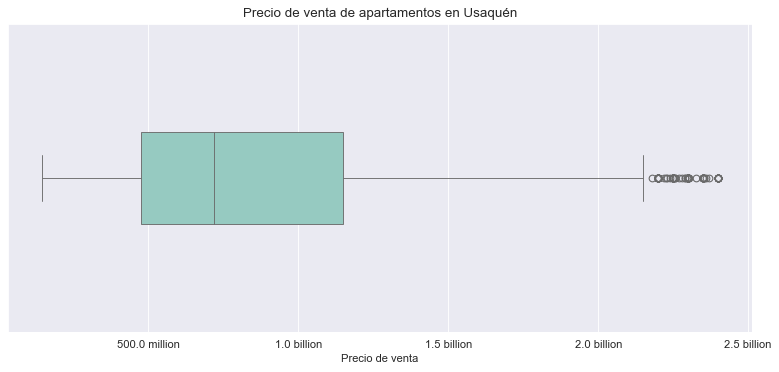

In [38]:
plt.figure(figsize=(12, 5))

sns.boxplot(
    usaquen,
    x='precio_venta',
    width=.3,
    palette='Set3',
    linewidth=.8,
)

plt.title('Precio de venta de apartamentos en Usaquén')
plt.xlabel('Precio de venta')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

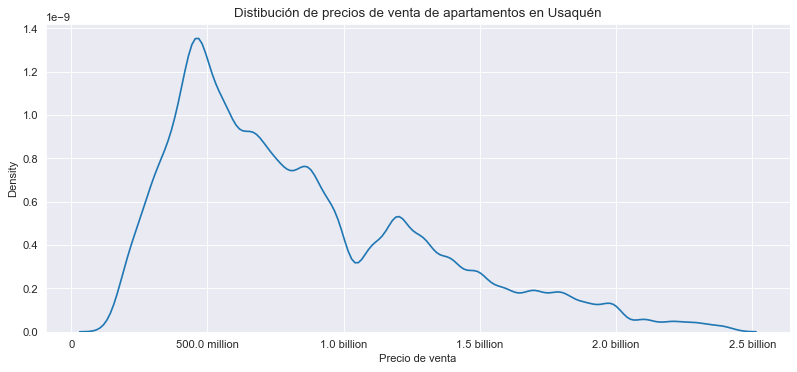

In [39]:
plt.figure(figsize=(12, 5))

sns.kdeplot(
    usaquen,
    x='precio_venta',
    bw_adjust=.5,
)

plt.title('Distibución de precios de venta de apartamentos en Usaquén')
plt.xlabel('Precio de venta')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

### Barrios

In [40]:
top_barrios = usaquen.groupby('barrio').agg(
    count=('barrio', 'count'),
    mean=('precio_venta', 'mean'),
    median=('precio_venta', 'median'),
    std=('precio_venta', 'std'),
)

# escoger los que tienen más de 20 registros para que sea más representativo
top_barrios_mean = top_barrios[top_barrios['count'] > 20].sort_values('mean', ascending=False).head(10)
top_barrios_mean.applymap(lambda x: humanize.intword(x))

count         mean       median  \
barrio                                                                
MONTEARROYO                            31  1.8 billion  1.8 billion   
SIERRAS DEL MORAL                      58  1.7 billion  1.7 billion   
BOSQUES DE MEDINA                     124  1.7 billion  1.7 billion   
SANTA ANA ORIENTAL                     61  1.6 billion  1.6 billion   
RESERVAS DE LA SIERRA - LA ARBOLEDA    48  1.6 billion  1.6 billion   
GINEBRA                                38  1.6 billion  1.7 billion   
LA CANADA                              57  1.4 billion  1.4 billion   
LOS ALPES II SECTOR                    77  1.4 billion  1.4 billion   
S.C. SAN NORTE                         24  1.4 billion  1.3 billion   
GINEBRA NORTE                          22  1.3 billion  1.3 billion   

                                               std  
barrio                                              
MONTEARROYO                          263.6 million  
SIERRAS DEL MORAL                    266.7 million  
BOSQUES DE MEDINA                    337.5 million  
SANTA ANA ORIENTAL                   502.2 million  
RESERVAS DE LA SIERRA - LA ARBOLEDA  255.8 million  
GINEBRA                              444.2 million  
LA CANADA                            274.0 million  
LOS ALPES II SECTOR                  257.9 million  
S.C. SAN NORTE                       302.0 million  
GINEBRA NORTE                        609.3 million

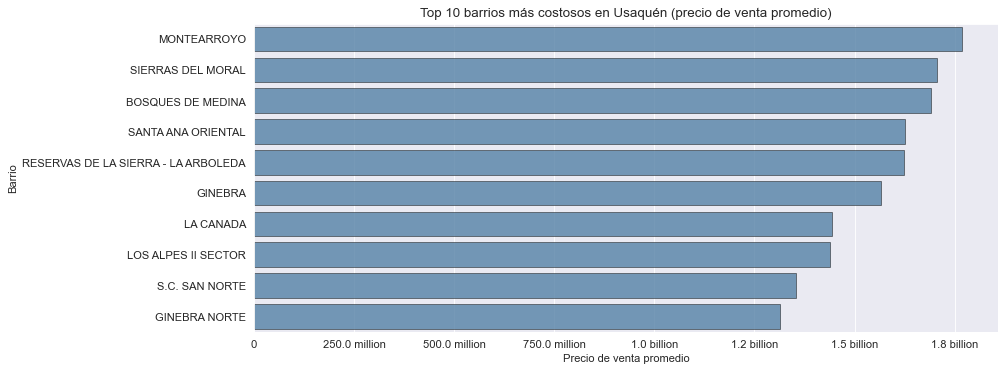

In [41]:
plt.figure(figsize=(12, 5), dpi=80)

sns.barplot(
    top_barrios_mean,
    y=top_barrios_mean.index,
    x='mean',
    color='steelblue',
    # palette='Set1',
    edgecolor='black',
    linewidth=.5,
    alpha=.8,
)

plt.title('Top 10 barrios más costosos en Usaquén (precio de venta promedio)')
plt.xlabel('Precio de venta promedio')
plt.ylabel('Barrio')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))

plt.show()

In [42]:
top_barrios_median = top_barrios[top_barrios['count'] > 20].sort_values('median', ascending=False).head(10)
top_barrios_median.applymap(lambda x: humanize.intword(x))

count         mean       median  \
barrio                                                                
MONTEARROYO                            31  1.8 billion  1.8 billion   
BOSQUES DE MEDINA                     124  1.7 billion  1.7 billion   
SIERRAS DEL MORAL                      58  1.7 billion  1.7 billion   
GINEBRA                                38  1.6 billion  1.7 billion   
SANTA ANA ORIENTAL                     61  1.6 billion  1.6 billion   
RESERVAS DE LA SIERRA - LA ARBOLEDA    48  1.6 billion  1.6 billion   
LOS ALPES II SECTOR                    77  1.4 billion  1.4 billion   
LA CANADA                              57  1.4 billion  1.4 billion   
GINEBRA NORTE                          22  1.3 billion  1.3 billion   
MOLINOS NORTE                          82  1.2 billion  1.3 billion   

                                               std  
barrio                                              
MONTEARROYO                          263.6 million  
BOSQUES DE MEDINA                    337.5 million  
SIERRAS DEL MORAL                    266.7 million  
GINEBRA                              444.2 million  
SANTA ANA ORIENTAL                   502.2 million  
RESERVAS DE LA SIERRA - LA ARBOLEDA  255.8 million  
LOS ALPES II SECTOR                  257.9 million  
LA CANADA                            274.0 million  
GINEBRA NORTE                        609.3 million  
MOLINOS NORTE                        401.1 million

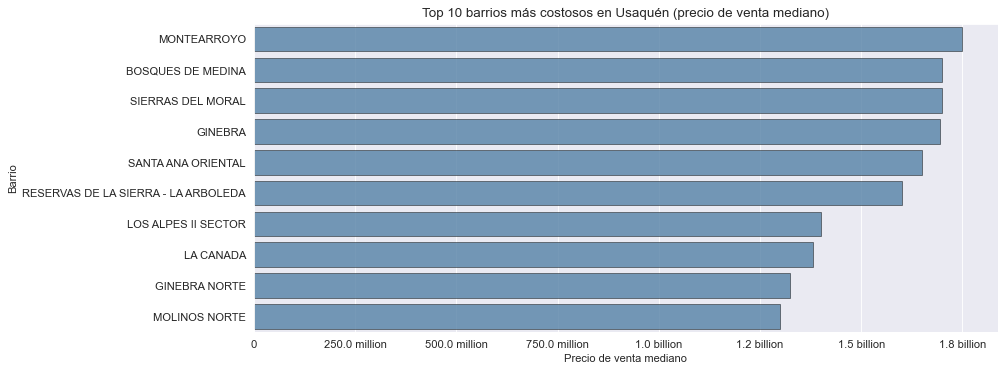

In [43]:
plt.figure(figsize=(12, 5))

sns.barplot(
    top_barrios_median,
    y=top_barrios_median.index,
    x='median',
    color='steelblue',
    edgecolor='black',
    linewidth=.5,
    alpha=.8,
)

plt.title('Top 10 barrios más costosos en Usaquén (precio de venta mediano)')
plt.xlabel('Precio de venta mediano')
plt.ylabel('Barrio')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

In [44]:
top_barrios_economicos = usaquen.groupby('barrio').agg(
    count=('barrio', 'count'),
    mean=('precio_venta', 'mean'),
    median=('precio_venta', 'median'),
    std=('precio_venta', 'std'),
)

top_barrios_economicos_mean = top_barrios_economicos[top_barrios_economicos['count'] > 10].sort_values('mean', ascending=True).head(10)
top_barrios_economicos_mean.applymap(lambda x: humanize.intword(x))

count           mean         median  \
barrio                                                                
URB. CARRERA 32 186-07             13  166.3 million  158.1 million   
SAN JOSE DE USAQUEN - URB. ARGO    16  185.5 million  186.5 million   
HORIZONTES USAQUEN                 23  212.6 million  222.8 million   
TIBABITA II                        21  219.8 million  195.0 million   
LAS ORQUIDEAS                      11  248.3 million  255.0 million   
LA GRANJA NORTE                    45  258.0 million  222.0 million   
TOBERIN                            14  267.6 million  252.0 million   
BALCONES DE ORIENTE                36  267.9 million  265.0 million   
S.C. HORIZONTES NORTE              13  271.8 million  275.0 million   
TIBABITA                           25  290.1 million  277.5 million   

                                          std  
barrio                                         
URB. CARRERA 32 186-07           14.9 million  
SAN JOSE DE USAQUEN - URB. ARGO  13.1 million  
HORIZONTES USAQUEN               21.0 million  
TIBABITA II                      53.6 million  
LAS ORQUIDEAS                    43.3 million  
LA GRANJA NORTE                  91.6 million  
TOBERIN                          43.8 million  
BALCONES DE ORIENTE              45.7 million  
S.C. HORIZONTES NORTE            21.4 million  
TIBABITA                         39.0 million

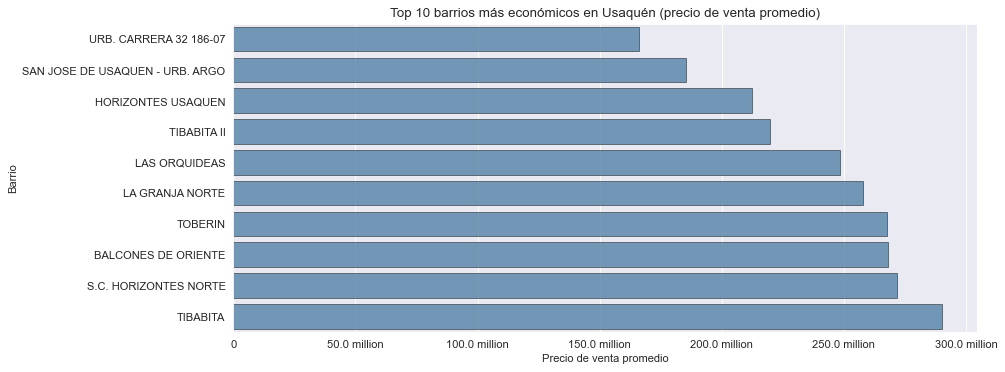

In [45]:
plt.figure(figsize=(12, 5))

sns.barplot(
    top_barrios_economicos_mean,
    y=top_barrios_economicos_mean.index,
    x='mean',
    color='steelblue',
    # palette='Set1',
    edgecolor='black',
    linewidth=.5,
    alpha=.8,
)

plt.title('Top 10 barrios más económicos en Usaquén (precio de venta promedio)')
plt.xlabel('Precio de venta promedio')
plt.ylabel('Barrio')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))

plt.show()

In [46]:
top_barrios_economicos_median = top_barrios_economicos[top_barrios_economicos['count'] > 10].sort_values('median', ascending=True).head(10)
top_barrios_economicos_median.applymap(lambda x: humanize.intword(x))

count           mean         median  \
barrio                                                                
URB. CARRERA 32 186-07             13  166.3 million  158.1 million   
SAN JOSE DE USAQUEN - URB. ARGO    16  185.5 million  186.5 million   
TIBABITA II                        21  219.8 million  195.0 million   
LA GRANJA NORTE                    45  258.0 million  222.0 million   
HORIZONTES USAQUEN                 23  212.6 million  222.8 million   
TOBERIN                            14  267.6 million  252.0 million   
LAS ORQUIDEAS                      11  248.3 million  255.0 million   
BALCONES DE ORIENTE                36  267.9 million  265.0 million   
BARRANCAS PERLAS DEL NORTE         18  400.1 million  272.5 million   
S.C. HORIZONTES NORTE              13  271.8 million  275.0 million   

                                           std  
barrio                                          
URB. CARRERA 32 186-07            14.9 million  
SAN JOSE DE USAQUEN - URB. ARGO   13.1 million  
TIBABITA II                       53.6 million  
LA GRANJA NORTE                   91.6 million  
HORIZONTES USAQUEN                21.0 million  
TOBERIN                           43.8 million  
LAS ORQUIDEAS                     43.3 million  
BALCONES DE ORIENTE               45.7 million  
BARRANCAS PERLAS DEL NORTE       271.4 million  
S.C. HORIZONTES NORTE             21.4 million

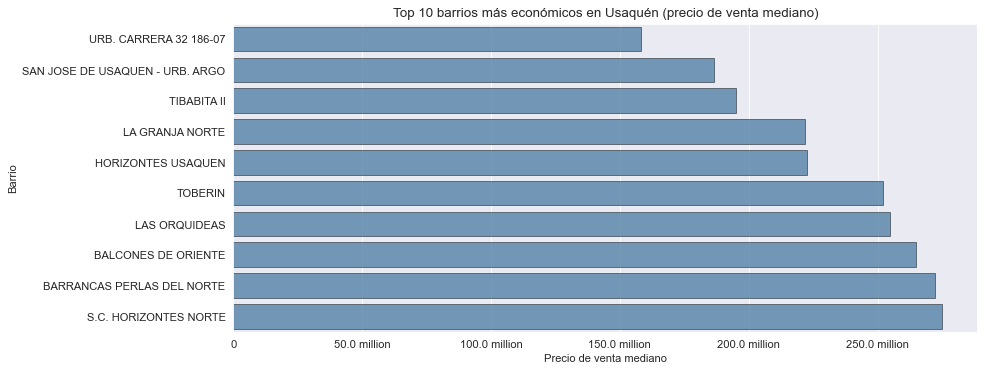

In [47]:
plt.figure(figsize=(12, 5))

sns.barplot(
    top_barrios_economicos_median,
    y=top_barrios_economicos_median.index,
    x='median',
    color='steelblue',
    edgecolor='black',
    linewidth=.5,
    alpha=.8,
)

plt.title('Top 10 barrios más económicos en Usaquén (precio de venta mediano)')
plt.xlabel('Precio de venta mediano')
plt.ylabel('Barrio')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

### Cercania a Transmilenio

In [48]:
usaquen.groupby('is_cerca_estacion_tm')['precio_venta'].describe().applymap(lambda x: humanize.intcomma(x))

count                 mean                   std  \
is_cerca_estacion_tm                                                       
0                     7,704.0  840,343,684.2662253    477,741,998.982834   
1                     1,231.0  854,411,602.1640942  400,580,220.00295717   

                                min            25%            50%  \
is_cerca_estacion_tm                                                
0                     145,000,000.0  469,000,000.0  700,000,000.0   
1                     240,000,000.0  567,000,000.0  780,000,000.0   

                                  75%              max  
is_cerca_estacion_tm                                    
0                     1,150,000,000.0  2,400,000,000.0  
1                     1,100,000,000.0  2,350,000,000.0

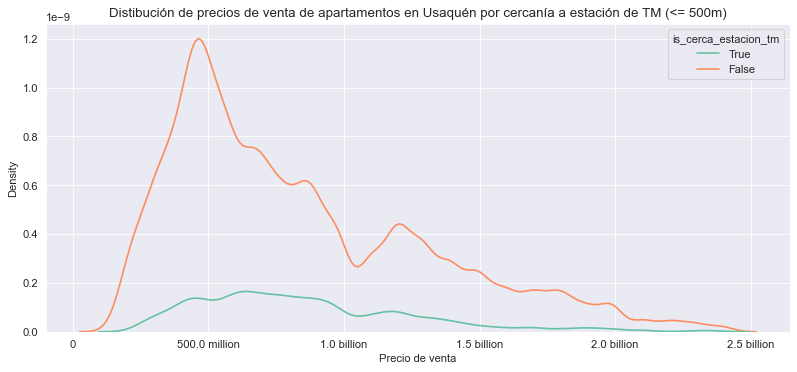

In [49]:
plt.figure(figsize=(12, 5))

sns.kdeplot(
    usaquen,
    x='precio_venta',
    bw_adjust=.5,
    hue='is_cerca_estacion_tm',
    hue_order=[True, False],
    palette='Set2',
)

plt.title('Distibución de precios de venta de apartamentos en Usaquén por cercanía a estación de TM (<= 500m)')
plt.xlabel('Precio de venta')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

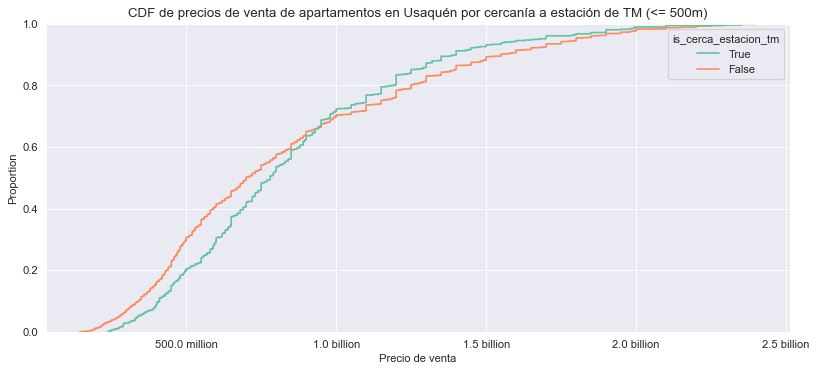

In [50]:
plt.figure(figsize=(12, 5))

sns.ecdfplot(
    usaquen,
    x='precio_venta',
    hue='is_cerca_estacion_tm',
    hue_order=[True, False],
    palette='Set2',
)

plt.title('CDF de precios de venta de apartamentos en Usaquén por cercanía a estación de TM (<= 500m)')
plt.xlabel('Precio de venta')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

### Estrato

In [51]:
usaquen.groupby('estrato')['precio_venta'].describe().applymap(lambda x: humanize.intword(x))

count           mean            std            min  \
estrato                                                              
1.0                 2  447.5 million  109.6 million  370.0 million   
2.0                33  265.3 million  172.0 million  170.0 million   
3.0               327  316.7 million  211.4 million  145.0 million   
4.0      1.9 thousand  462.6 million  172.7 million  170.0 million   
5.0      2.2 thousand  788.2 million  374.4 million  205.0 million   
6.0      4.5 thousand    1.1 billion  463.4 million  225.0 million   

                   25%            50%            75%            max  
estrato                                                              
1.0      408.8 million  447.5 million  486.2 million  525.0 million  
2.0      191.5 million  199.0 million  220.0 million    1.0 billion  
3.0      215.0 million  250.0 million  320.0 million    1.9 billion  
4.0      350.0 million  440.0 million  527.3 million    1.6 billion  
5.0      510.0 million  695.0 million  950.0 million    2.4 billion  
6.0      700.0 million  980.0 million    1.4 billion    2.4 billion

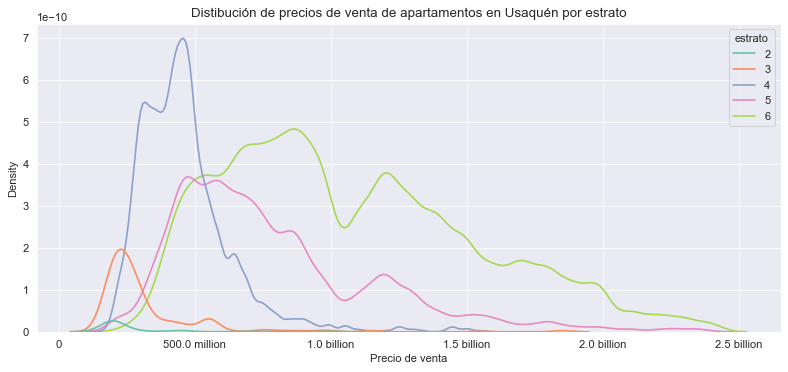

In [55]:
plt.figure(figsize=(12, 5))

sns.kdeplot(
    usaquen,
    x='precio_venta',
    bw_adjust=.5,
    hue='estrato',
    hue_order=[2, 3, 4, 5, 6],
    palette='Set2',
)

plt.title('Distibución de precios de venta de apartamentos en Usaquén por estrato')
plt.xlabel('Precio de venta')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

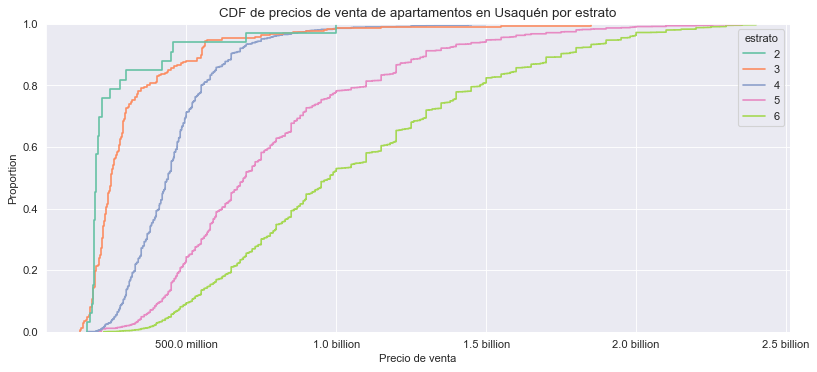

In [54]:
plt.figure(figsize=(12, 5))

sns.ecdfplot(
    usaquen,
    x='precio_venta',
    hue='estrato',
    hue_order=[2, 3, 4, 5, 6],
    palette='Set2',
)

plt.title('CDF de precios de venta de apartamentos en Usaquén por estrato')
plt.xlabel('Precio de venta')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

### Antiguedad del apartamento

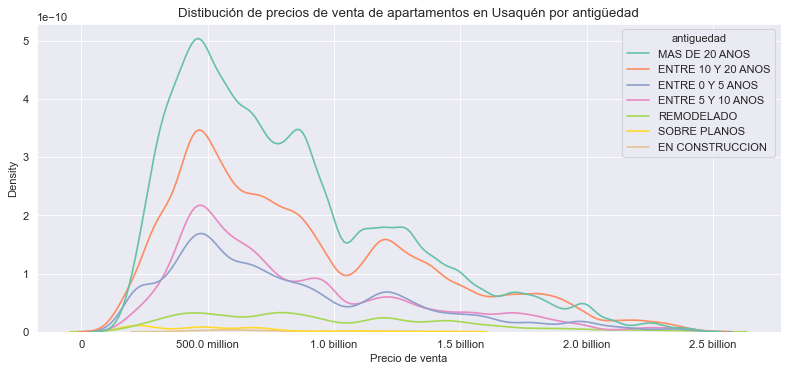

In [56]:
plt.figure(figsize=(12, 5))

sns.kdeplot(
    usaquen,
    x='precio_venta',
    bw_adjust=.5,
    hue='antiguedad',
    palette='Set2',
)

plt.title('Distibución de precios de venta de apartamentos en Usaquén por antigüedad')
plt.xlabel('Precio de venta')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

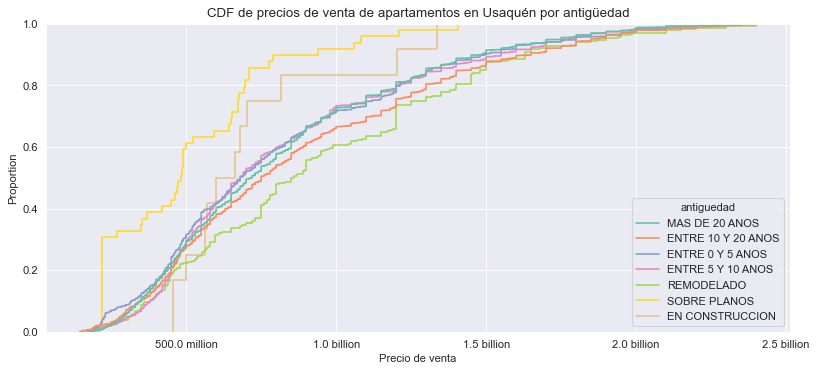

In [57]:
plt.figure(figsize=(12, 5))

sns.ecdfplot(
    usaquen,
    x='precio_venta',
    hue='antiguedad',
    palette='Set2',
)

plt.title('CDF de precios de venta de apartamentos en Usaquén por antigüedad')
plt.xlabel('Precio de venta')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

### Estacion de TM Cercana

In [58]:
estacion_tm_cercana.groupby('estacion_tm_cercana')['precio_venta'].describe().sort_values('mean', ascending=False).applymap(lambda x: humanize.intword(x))

count           mean            std  \
estacion_tm_cercana                                                       
Calle 106                             357    1.1 billion  395.9 million   
Calle 100 - Marketmedios               30    1.0 billion  462.0 million   
Calle 127                             198  897.8 million  361.0 million   
Pepe Sierra                           252  888.1 million  338.5 million   
Prado                                 119  883.1 million  416.0 million   
Alcalá – Colegio S. Tomás Dominicos    92  593.0 million  225.3 million   
Calle 146                              37  508.8 million  235.9 million   
Calle 142                              94  483.0 million  134.0 million   
Calle 187                              13  443.8 million  198.4 million   
Mazurén                                15  442.7 million   85.9 million   
Calle 161                              18  305.0 million   79.8 million   
Portal Norte                            5  286.4 million    8.3 million   
Toberin - Foundever                     1  250.0 million            NaN   

                                               min            25%  \
estacion_tm_cercana                                                 
Calle 106                            380.0 million  768.2 million   
Calle 100 - Marketmedios             400.0 million  795.0 million   
Calle 127                            257.0 million  636.2 million   
Pepe Sierra                          330.0 million  640.0 million   
Prado                                320.0 million  599.0 million   
Alcalá – Colegio S. Tomás Dominicos  325.0 million  450.0 million   
Calle 146                            250.0 million  420.0 million   
Calle 142                            240.0 million  361.2 million   
Calle 187                            265.0 million  290.1 million   
Mazurén                              315.0 million  411.0 million   
Calle 161                            240.0 million  256.2 million   
Portal Norte                         275.0 million  281.0 million   
Toberin - Foundever                  250.0 million  250.0 million   

                                               50%            75%  \
estacion_tm_cercana                                                 
Calle 106                            950.0 million    1.2 billion   
Calle 100 - Marketmedios             902.3 million    1.2 billion   
Calle 127                            835.0 million    1.1 billion   
Pepe Sierra                          845.0 million    1.1 billion   
Prado                                750.0 million  990.0 million   
Alcalá – Colegio S. Tomás Dominicos  555.0 million  690.0 million   
Calle 146                            465.0 million  496.0 million   
Calle 142                            475.0 million  598.8 million   
Calle 187                            440.0 million  460.0 million   
Mazurén                              411.0 million  411.0 million   
Calle 161                            275.0 million  333.8 million   
Portal Norte                         290.0 million  290.0 million   
Toberin - Foundever                  250.0 million  250.0 million   

                                               max  
estacion_tm_cercana                                 
Calle 106                              2.4 billion  
Calle 100 - Marketmedios               2.1 billion  
Calle 127                              2.4 billion  
Pepe Sierra                            1.9 billion  
Prado                                  2.4 billion  
Alcalá – Colegio S. Tomás Dominicos    1.3 billion  
Calle 146                              1.5 billion  
Calle 142                            750.0 million  
Calle 187                            900.0 million  
Mazurén                              605.0 million  
Calle 161                            550.0 million  
Portal Norte                         295.9 million  
Toberin - Foundever                  250.0 million

In [59]:
estacion_tm_cercana_stats_mean = estacion_tm_cercana.groupby('estacion_tm_cercana')['precio_venta'].describe().sort_values('mean', ascending=False)
estacion_tm_cercana_stats_median = estacion_tm_cercana.groupby('estacion_tm_cercana')['precio_venta'].describe().sort_values('50%', ascending=False)

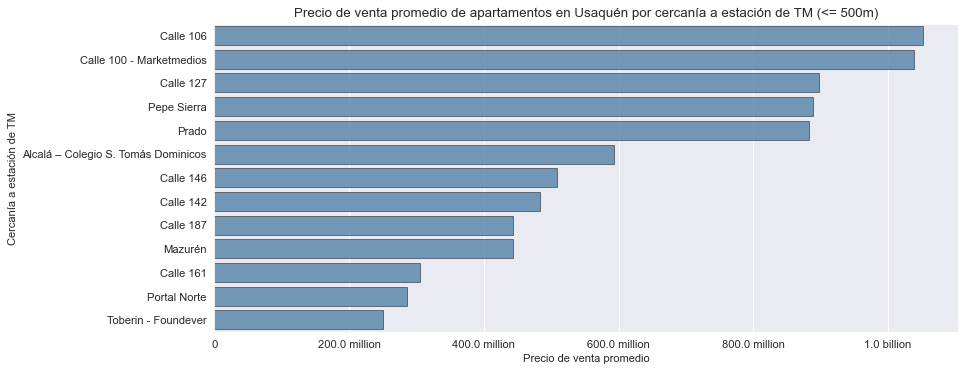

In [60]:
plt.figure(figsize=(12, 5))

sns.barplot(
    estacion_tm_cercana_stats_mean,
    y=estacion_tm_cercana_stats_mean.index,
    x='mean',
    color='steelblue',
    # palette='Set1',
    edgecolor='black',
    linewidth=.5,
    alpha=.8,
)

plt.title('Precio de venta promedio de apartamentos en Usaquén por cercanía a estación de TM (<= 500m)')
plt.xlabel('Precio de venta promedio')
plt.ylabel('Cercanía a estación de TM')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

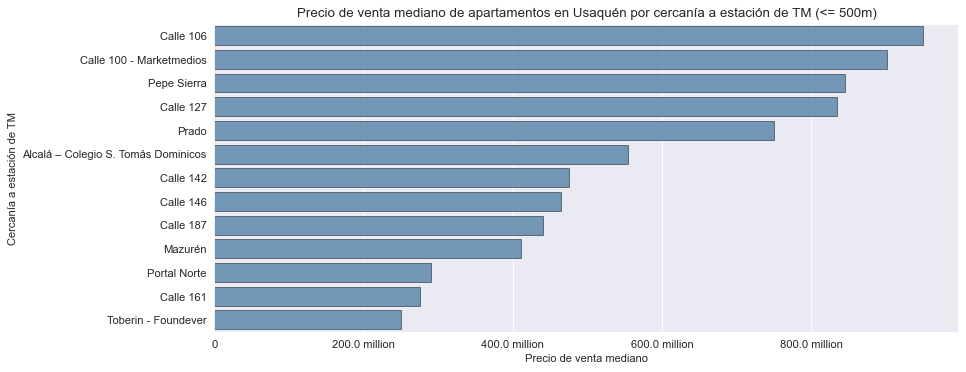

In [61]:
plt.figure(figsize=(12, 5))

sns.barplot(
    estacion_tm_cercana_stats_median,
    y=estacion_tm_cercana_stats_median.index,
    x='50%',
    color='steelblue',
    # palette='Set1',
    edgecolor='black',
    linewidth=.5,
    alpha=.8,
)

plt.title('Precio de venta mediano de apartamentos en Usaquén por cercanía a estación de TM (<= 500m)')
plt.xlabel('Precio de venta mediano')
plt.ylabel('Cercanía a estación de TM')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

<Figure size 960x400 with 0 Axes>

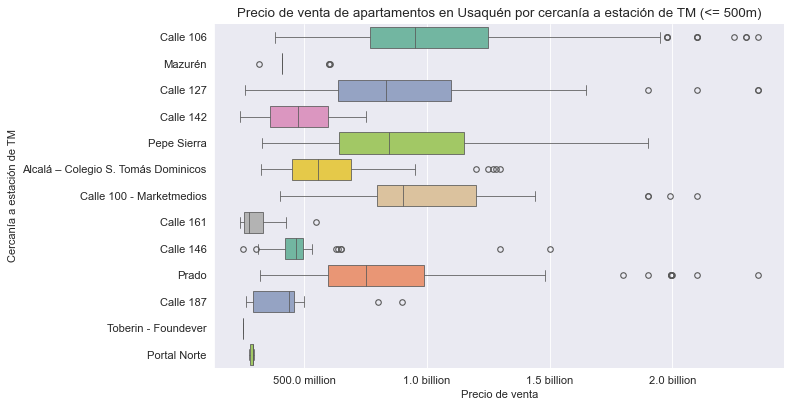

In [62]:
plt.figure(figsize=(12, 5))

sns.catplot(
    data=estacion_tm_cercana,
    x='precio_venta',
    y='estacion_tm_cercana',
    kind='box',
    height=5,
    aspect=2,
    palette='Set2',
    orient='h',
    linewidth=.7,
)

plt.title('Precio de venta de apartamentos en Usaquén por cercanía a estación de TM (<= 500m)')
plt.xlabel('Precio de venta')
plt.ylabel('Cercanía a estación de TM')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

### Precios Anteriores Vs Actuales

## Antiguedad

In [63]:
usaquen.antiguedad.value_counts()

antiguedad
MAS DE 20 ANOS        3616
ENTRE 10 Y 20 ANOS    2540
ENTRE 5 Y 10 ANOS     1263
ENTRE 0 Y 5 ANOS      1126
REMODELADO             328
SOBRE PLANOS            49
EN CONSTRUCCION         12
Name: count, dtype: int64

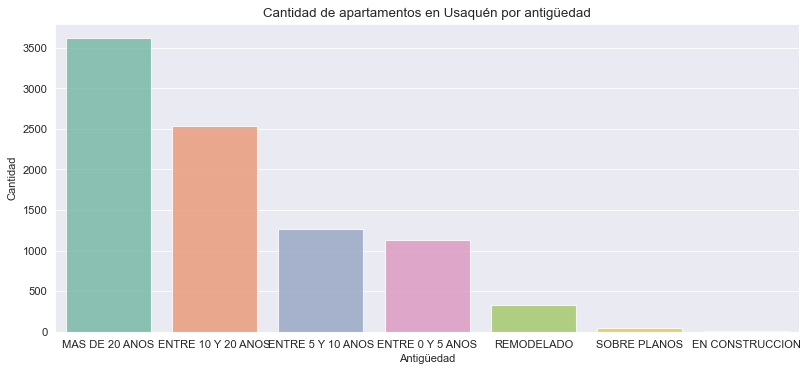

In [64]:
plt.figure(figsize=(12, 5))

sns.countplot(
    usaquen,
    x='antiguedad',
    order=usaquen.antiguedad.value_counts().index,
    palette='Set2',
    # edgecolor='black',
    # linewidth=.5,
    alpha=.8,
)

plt.title('Cantidad de apartamentos en Usaquén por antigüedad')
plt.xlabel('Antigüedad')
plt.ylabel('Cantidad')
plt.show()

### Barrios

In [65]:
usaquen.groupby('antiguedad')['barrio'].describe()

count unique                       top freq
antiguedad                                                    
EN CONSTRUCCION       12      3    SANTA BARBARA ORIENTAL    6
ENTRE 0 Y 5 ANOS    1114     89  SANTA BARBARA OCCIDENTAL  167
ENTRE 10 Y 20 ANOS  2524    127             SANTA BIBIANA  222
ENTRE 5 Y 10 ANOS   1250    104  SANTA BARBARA OCCIDENTAL  153
MAS DE 20 ANOS      3584    139  SANTA BARBARA OCCIDENTAL  342
REMODELADO           322     71  SANTA BARBARA OCCIDENTAL   48
SOBRE PLANOS          49      4               EL CONTADOR   34

In [66]:
usaquen.groupby('antiguedad')['area'].describe().apply(lambda x: round(x,1))

count   mean   std   min   25%    50%    75%    max
antiguedad                                                              
EN CONSTRUCCION       12.0   67.1  20.4  50.0  52.9   60.3   72.3  110.0
ENTRE 0 Y 5 ANOS    1126.0   94.6  48.5   1.0  59.0   82.0  125.0  300.0
ENTRE 10 Y 20 ANOS  2540.0  130.6  59.6   1.0  84.2  117.6  169.0  302.7
ENTRE 5 Y 10 ANOS   1263.0  112.0  51.4  27.0  73.0  100.0  140.0  290.0
MAS DE 20 ANOS      3616.0  139.7  61.6   1.0  89.9  129.0  180.0  304.0
REMODELADO           328.0  141.7  58.2  22.6  89.8  140.0  180.0  300.0
SOBRE PLANOS          49.0   44.0  21.6  21.0  22.3   42.5   61.5  105.3

In [67]:
usaquen.groupby('barrio')['antiguedad'].describe().sort_values(by='count', ascending=False).head(10)

count unique                 top freq
barrio                                                              
SANTA BARBARA OCCIDENTAL         916      5      MAS DE 20 ANOS  342
SAN PATRICIO                     653      5      MAS DE 20 ANOS  220
SANTA BIBIANA                    632      5      MAS DE 20 ANOS  244
LA_CAROLINA                      319      5      MAS DE 20 ANOS  183
SANTA BARBARA CENTRAL I Y II     305      6      MAS DE 20 ANOS   88
SANTA BARBARA CENTRAL I SECTOR   305      5      MAS DE 20 ANOS  172
RINCON DEL CHICO                 301      5      MAS DE 20 ANOS  160
BELLA SUIZA                      259      5  ENTRE 10 Y 20 ANOS   79
LISBOA_                          232      5  ENTRE 10 Y 20 ANOS  118
LOS CEDRITOS                     221      5      MAS DE 20 ANOS   80

### Estrato

In [69]:
usaquen.groupby('barrio').agg(
    count=('barrio', 'count'),
    mean=('estrato', 'mean'),
    median=('estrato', 'median'),
    std=('estrato', 'std'),
).sort_values(by='count', ascending=False).head(10)

count      mean  median       std
barrio                                                           
SANTA BARBARA OCCIDENTAL          917  5.497274     6.0  0.542156
SAN PATRICIO                      653  5.935681     6.0  0.274975
SANTA BIBIANA                     632  5.952532     6.0  0.220128
LA_CAROLINA                       319  5.946708     6.0  0.275259
SANTA BARBARA CENTRAL I SECTOR    305  5.872131     6.0  0.344186
SANTA BARBARA CENTRAL I Y II      305  5.875410     6.0  0.340595
RINCON DEL CHICO                  301  5.554817     6.0  0.628080
BELLA SUIZA                       259  5.027027     5.0  0.416756
LISBOA_                           232  5.000000     5.0  0.335491
LOS CEDRITOS                      221  4.104072     4.0  0.347761

## Barrios

In [70]:
usaquen.groupby('barrio')['codigo'].count().sort_values(ascending=False).to_frame().head(10)

codigo
barrio                                
SANTA BARBARA OCCIDENTAL           917
SAN PATRICIO                       653
SANTA BIBIANA                      632
LA_CAROLINA                        319
SANTA BARBARA CENTRAL I SECTOR     305
SANTA BARBARA CENTRAL I Y II       305
RINCON DEL CHICO                   301
BELLA SUIZA                        259
LISBOA_                            232
LOS CEDRITOS                       221

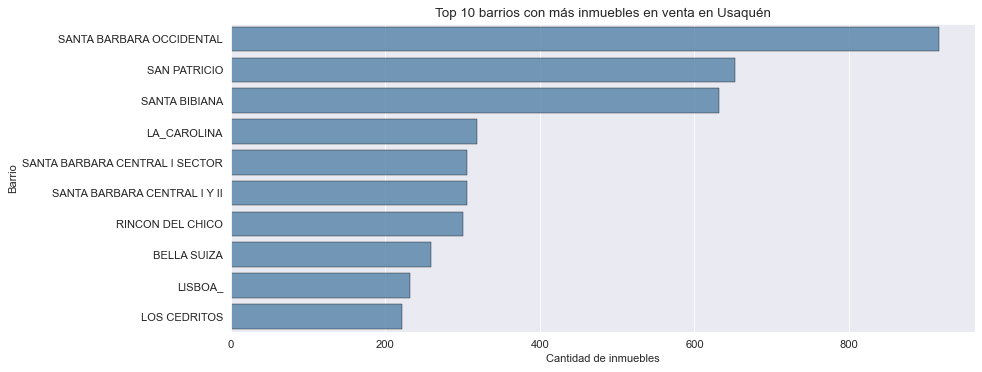

In [71]:
plt.figure(figsize=(12, 5))

sns.barplot(
    data=usaquen.groupby('barrio')['codigo'].count().sort_values(ascending=False).to_frame().head(10),
    x='codigo',
    y=usaquen.groupby('barrio')['codigo'].count().sort_values(ascending=False).to_frame().head(10).index,
    # palette='Set2',
    color='steelblue',
    orient='h',
    edgecolor='black',
    linewidth=.4,
    alpha=.8
)

plt.title('Top 10 barrios con más inmuebles en venta en Usaquén')
plt.xlabel('Cantidad de inmuebles')
plt.ylabel('Barrio')
plt.show()

In [73]:
# apartamentos mas costoso por parque cercano

# usaquen.groupby('parque_cercano')['precio_venta'].describe().applymap(lambda x: humanize.intword(x))
parque_cercano_stats = usaquen.groupby('parque_cercano')['precio_venta'].describe().applymap(lambda x: round(x, 1))
parque_cercano_stats

count          mean  \
parque_cercano                                                             
PARQUE METROPOLITANO EL COUNTRY                     3986.0  9.978415e+08   
PARQUE VECINAL DESARROLLO ESTRELLA DEL NORTE          91.0  3.932523e+08   
PARQUE VECINAL DESARROLLO VERBENAL I                 149.0  3.053036e+08   
PARQUE VECINAL NUEVA URBANIZACIÓN EL CEDRITO        1556.0  7.101278e+08   
PARQUE VECINAL PRADO PINZÓN                          409.0  5.519633e+08   
PARQUE VECINAL URBANIZACIÓN CALLE 170 / ALAMEDA      223.0  3.816856e+08   
PARQUE VECINAL URBANIZACIÓN LA CABRERA                 4.0  9.014975e+08   
PARQUE VECINAL URBANIZACIÓN MAZUREN I SECTOR           3.0  7.666667e+08   
PARQUE VECINAL URBANIZACIÓN NORMANDIA I II II Y...   558.0  1.046276e+09   
PARQUE VECINAL URBANIZACIÓN TOBERIN                   98.0  3.691502e+08   
PARQUE VECINAL URBANIZACIÓN VICTORIA NORTE             2.0  9.500000e+08   
PARQUE ZONAL ALTA BLANCA                             191.0  6.022041e+08   
PARQUE ZONAL ATABANZA                                717.0  8.939362e+08   
PARQUE ZONAL CANAL CORDOBA                           325.0  1.019798e+09   
PARQUE ZONAL CANAL EL VIRREY EL CHICO                218.0  8.076357e+08   
PARQUE ZONAL LA VIDA                                 196.0  4.250437e+08   
PARQUE ZONAL SERVITA                                 209.0  3.669972e+08   

                                                            std          min  \
parque_cercano                                                                 
PARQUE METROPOLITANO EL COUNTRY                     467009678.7  210000000.0   
PARQUE VECINAL DESARROLLO ESTRELLA DEL NORTE        107897305.9  148000000.0   
PARQUE VECINAL DESARROLLO VERBENAL I                135775135.7  148700000.0   
PARQUE VECINAL NUEVA URBANIZACIÓN EL CEDRITO        451137149.2  195000000.0   
PARQUE VECINAL PRADO PINZÓN                         235841881.1  210000000.0   
PARQUE VECINAL URBANIZACIÓN CALLE 170 / ALAMEDA     151514111.2  145000000.0   
PARQUE VECINAL URBANIZACIÓN LA CABRERA              665292143.9  205990000.0   
PARQUE VECINAL URBANIZACIÓN MAZUREN I SECTOR        640104158.2  320000000.0   
PARQUE VECINAL URBANIZACIÓN NORMANDIA I II II Y...  424474013.4  280000000.0   
PARQUE VECINAL URBANIZACIÓN TOBERIN                 105646623.9  210000000.0   
PARQUE VECINAL URBANIZACIÓN VICTORIA NORTE          494974746.8  600000000.0   
PARQUE ZONAL ALTA BLANCA                            419606652.4  190000000.0   
PARQUE ZONAL ATABANZA                               353894054.6  257000000.0   
PARQUE ZONAL CANAL CORDOBA                          407114023.1  330000000.0   
PARQUE ZONAL CANAL EL VIRREY EL CHICO               336552111.9  300000000.0   
PARQUE ZONAL LA VIDA                                144144448.3  195000000.0   
PARQUE ZONAL SERVITA                                245536998.5  160000000.0   

                                                            25%          50%  \
parque_cercano                                                                 
PARQUE METROPOLITANO EL COUNTRY                     630000000.0  895000000.0   
PARQUE VECINAL DESARROLLO ESTRELLA DEL NORTE        315000000.0  400000000.0   
PARQUE VECINAL DESARROLLO VERBENAL I                200000000.0  275000000.0   
PARQUE VECINAL NUEVA URBANIZACIÓN EL CEDRITO        423300000.0  520000000.0   
PARQUE VECINAL PRADO PINZÓN                         390000000.0  496000000.0   
PARQUE VECINAL URBANIZACIÓN CALLE 170 / ALAMEDA     250000000.0  383000000.0   
PARQUE VECINAL URBANIZACIÓN LA CABRERA              583997500.0  800000000.0   
PARQUE VECINAL URBANIZACIÓN MAZUREN I SECTOR        400000000.0  480000000.0   
PARQUE VECINAL URBANIZACIÓN NORMANDIA I II II Y...  742500000.0  942500000.0   
PARQUE VECINAL URBANIZACIÓN TOBERIN                 270500000.0  382500000.0   
PARQUE VECINAL URBANIZACIÓN VICTORIA NORTE          775000000.0  950000000.0   
PARQUE ZONAL ALTA BLANCA                       

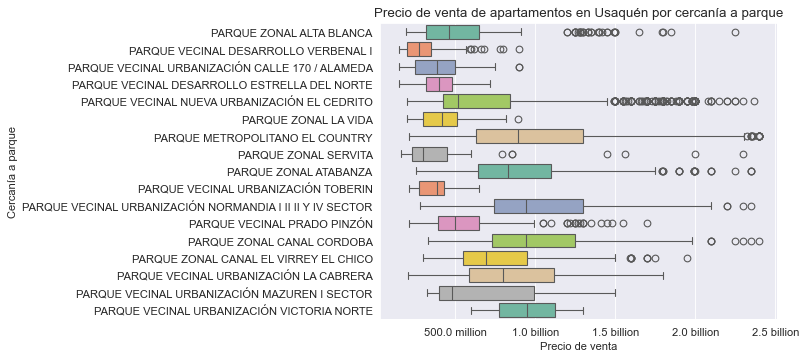

In [74]:
sns.boxplot(
    usaquen,
    x='precio_venta',
    y='parque_cercano',
    palette='Set2',
)

plt.title('Precio de venta de apartamentos en Usaquén por cercanía a parque')
plt.xlabel('Precio de venta')
plt.ylabel('Cercanía a parque')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

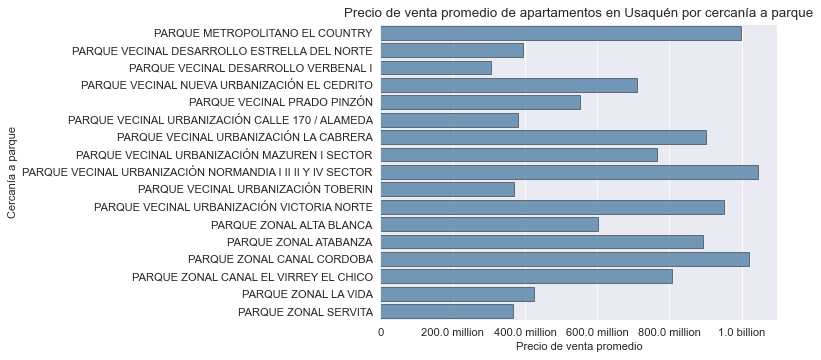

In [75]:
sns.barplot(
    parque_cercano_stats,
    y=parque_cercano_stats.index,
    x='mean',
    color='steelblue',
    edgecolor='black',
    linewidth=.5,
    alpha=.8,
)

plt.title('Precio de venta promedio de apartamentos en Usaquén por cercanía a parque')
plt.xlabel('Precio de venta promedio')
plt.ylabel('Cercanía a parque')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()